In [1]:
cd ..

/Users/estevao.uyra/dev/personal/criticality-on-neural-network


In [2]:
import sys
import pickle
sys.path.append("./src")
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

In [6]:
from network import Network
import connectivity as conn
from itertools import product
from visuals import loglogdensity
from analysis import avalanche_basic_stats

import pickle
from tqdm.notebook import tqdm

In [4]:
topologies = {
    'full': lambda prop: conn.fully_connected_network(500, proportion_inhib=prop),
    'small_world': lambda prop: conn.small_world_network(500, 4, .1, proportion_inhib=prop),
    'scale_free': lambda prop: conn.neuron_scale_free_network(500, 100, proportion_inhib=prop)
}

In [19]:
for topol_name, topol_fn in topologies.items():
    for i in tqdm(range(30)): # ex. range(3, 30)
        net = Network(W=topol_fn(0.3),
                      omega=4.5,
                      synaptic_efficacy=.3)

        # High stim intensity
        net.run_schedule(stim_durations = [   100,   100,  100,  200, 20000], 
                         stim_strenghts = [.00005, .0005, .005, 0.01,  .005])


        filepath = f'data/spikes_{i}_topol_{topol_name}.pkl'
        spikes_i = net.get_history('s')
        pickle.dump(coo_matrix(spikes_i), open(filepath, 'wb'))

# Analyses

In [7]:
all_stats = []
for topol_name, topol_fn in topologies.items():
    for i in tqdm(range(30)): # ex. range(3, 30)
        
        filepath = f'data/spikes_{i}_topol_{topol_name}.pkl'
        m = np.array(pickle.load(open(filepath,'rb')).todense())
        tot, sizes, dur = avalanche_basic_stats(m[:,1000:10000])

        stats = pd.DataFrame(
            dict(
                i = i,
                topol = topol_name,
                total_avalanches = tot,
                avalanche_sizes = [sizes],
                avalanche_durations = [dur],
                total_spikes = m.sum(),
                filename = filepath
            ))
        all_stats.append(stats)
        
all_stats = pd.concat(all_stats)        

In [11]:
all_stats.to_csv('stats_rounded_values.csv')

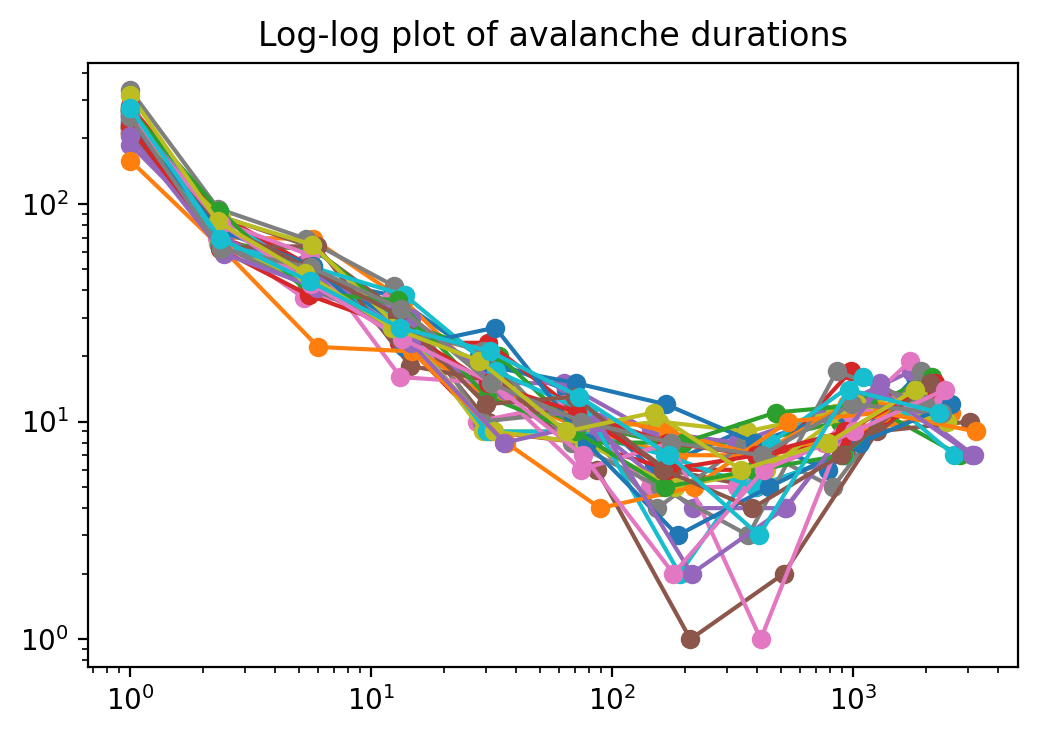

In [61]:
plt.figure(dpi=200)
all_stats.query('topol == "full"').avalanche_sizes.apply(loglogdensity);

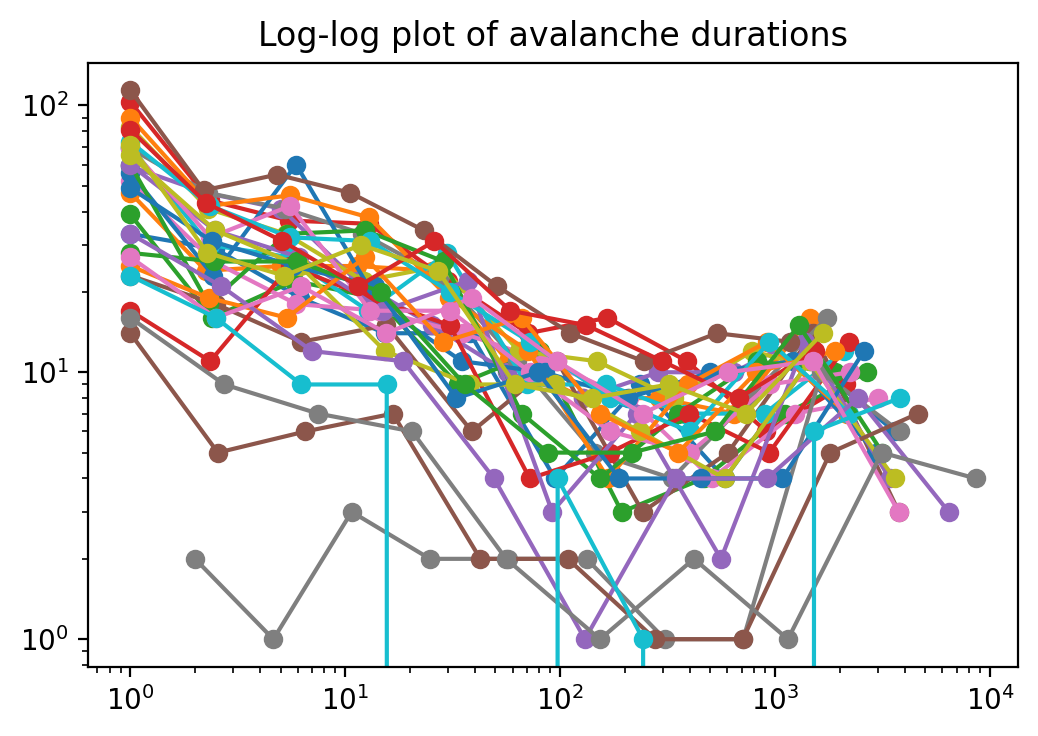

In [62]:
plt.figure(dpi=200)
all_stats.query('topol == "small_world"').avalanche_sizes.apply(loglogdensity);

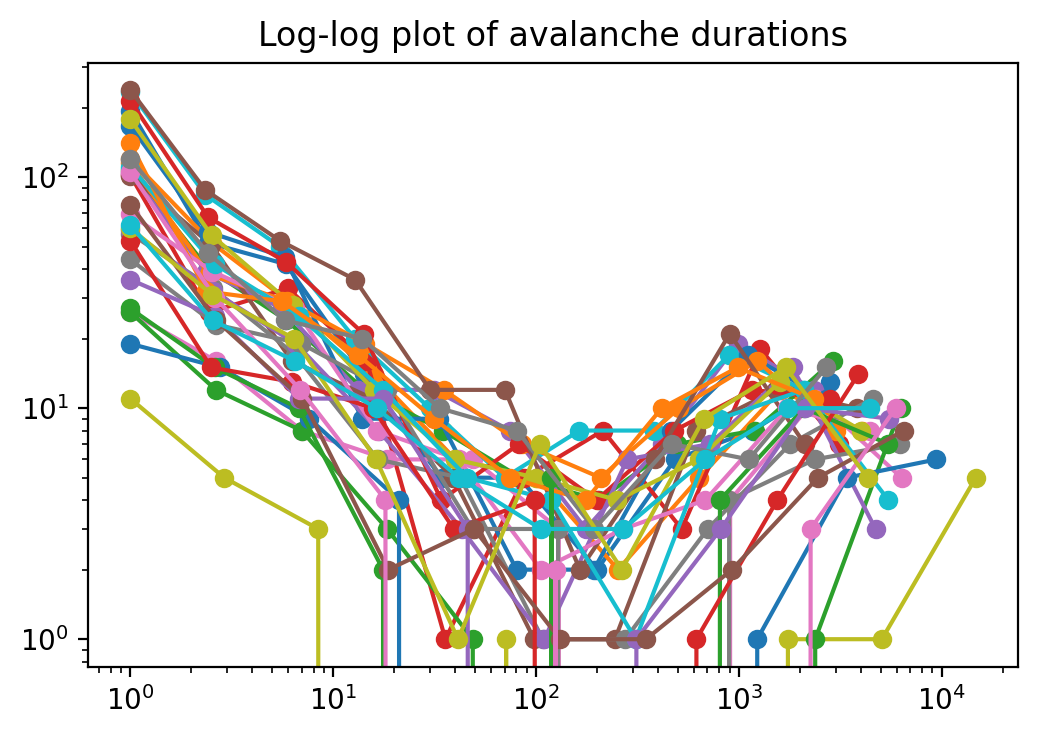

In [63]:
plt.figure(dpi=200)
all_stats.query('topol == "scale_free"').avalanche_sizes.apply(loglogdensity);

---

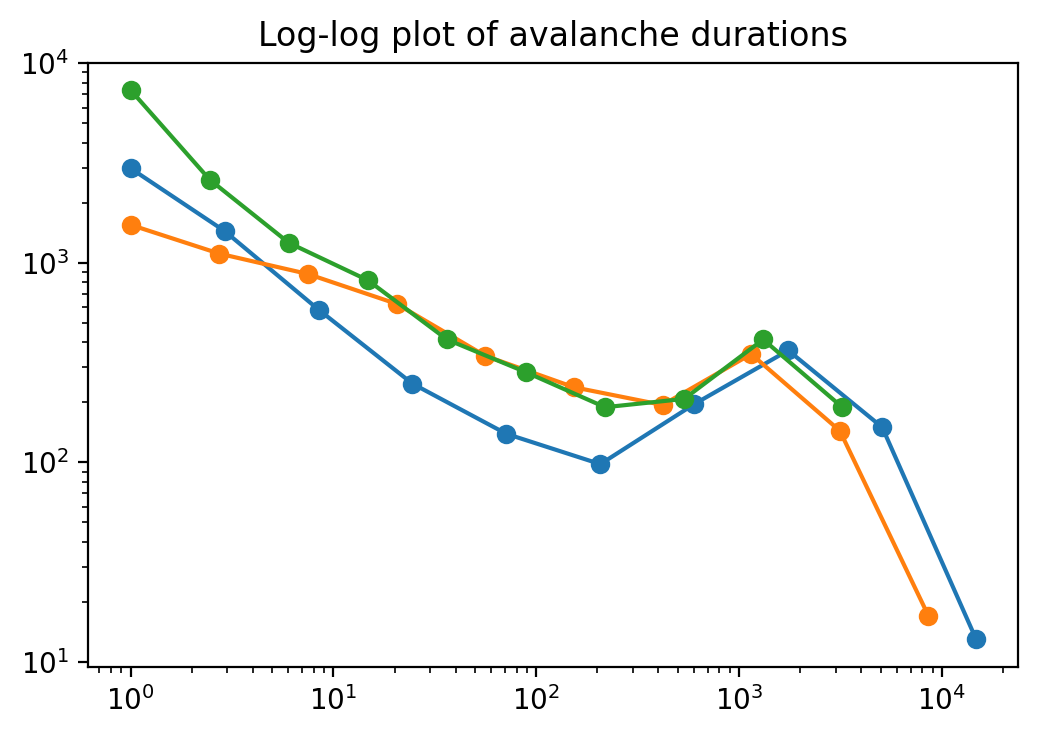

In [64]:
loglogdensity(np.hstack(all_stats.query('topol == "scale_free"').avalanche_sizes.values))
loglogdensity(np.hstack(all_stats.query('topol == "small_world"').avalanche_sizes.values))
loglogdensity(np.hstack(all_stats.query('topol == "full"').avalanche_sizes.values))

In [59]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://pypi.nubank.com.br/pypi
Processing /Users/estevao.uyra/Library/Caches/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601/powerlaw-1.4.6-cp37-none-any.whl
     |████████████████████████████████| 512 kB 5.2 MB/s eta 0:00:01
  Created wheel for mpmath: filename=mpmath-1.1.0-py3-none-any.whl size=532239 sha256=a475018c086f8d523c7f24a52818c7223cad4b558c99cb75ecf7547921fe88cd
  Stored in directory: /Users/estevao.uyra/Library/Caches/pip/wheels/e2/46/78/e78f76c356bca9277368f1f97a31b37a8cb937176d9511af31
Successfully built mpmath


In [73]:
scale_free_sizes = np.hstack(all_stats.query('topol == "scale_free"').avalanche_sizes.values)
scale_free_durations = np.hstack(all_stats.query('topol == "scale_free"').avalanche_durations.values)

In [80]:
durations

1.800921078459608
1.0
1.853367392196382
5.0


Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


<AxesSubplot:>

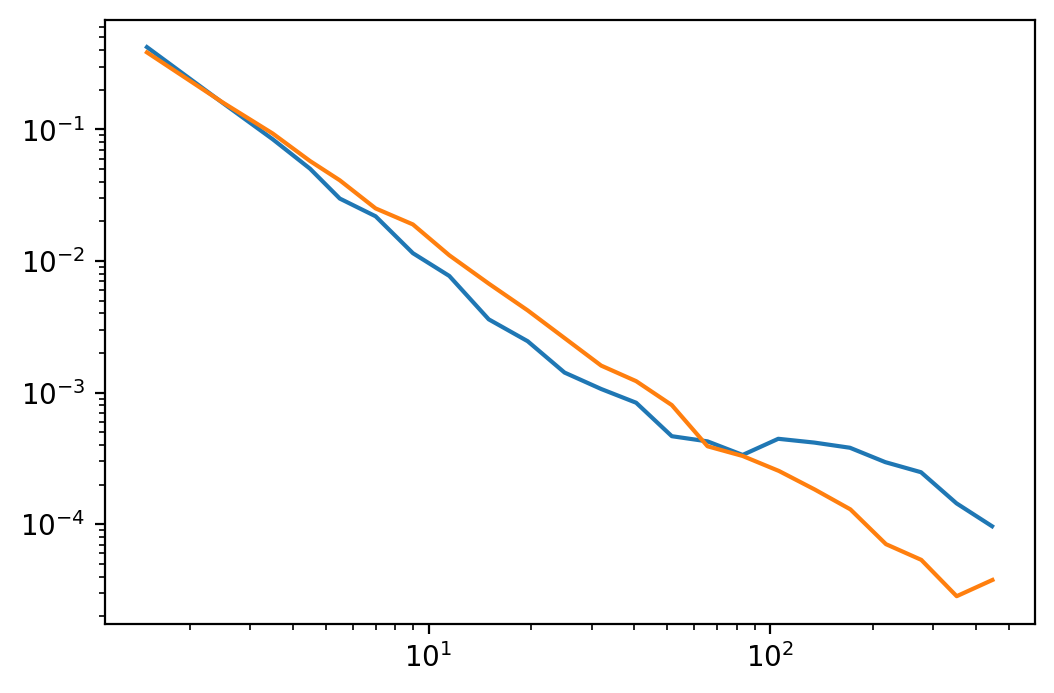

In [84]:

import powerlaw
scale_free_durations = powerlaw.trim_to_range(scale_free_durations, xmin = 1, xmax = 500)
scale_free_sizes = powerlaw.trim_to_range(scale_free_sizes, xmin = 1, xmax = 500)


durations = powerlaw.Fit(scale_free_durations)
print(durations.power_law.alpha)
print(durations.power_law.xmin)

sizes = powerlaw.Fit(scale_free_sizes)
print(sizes.power_law.alpha)
print(sizes.power_law.xmin)



In [109]:
sns.set_palette('deep', color_codes=True)

Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


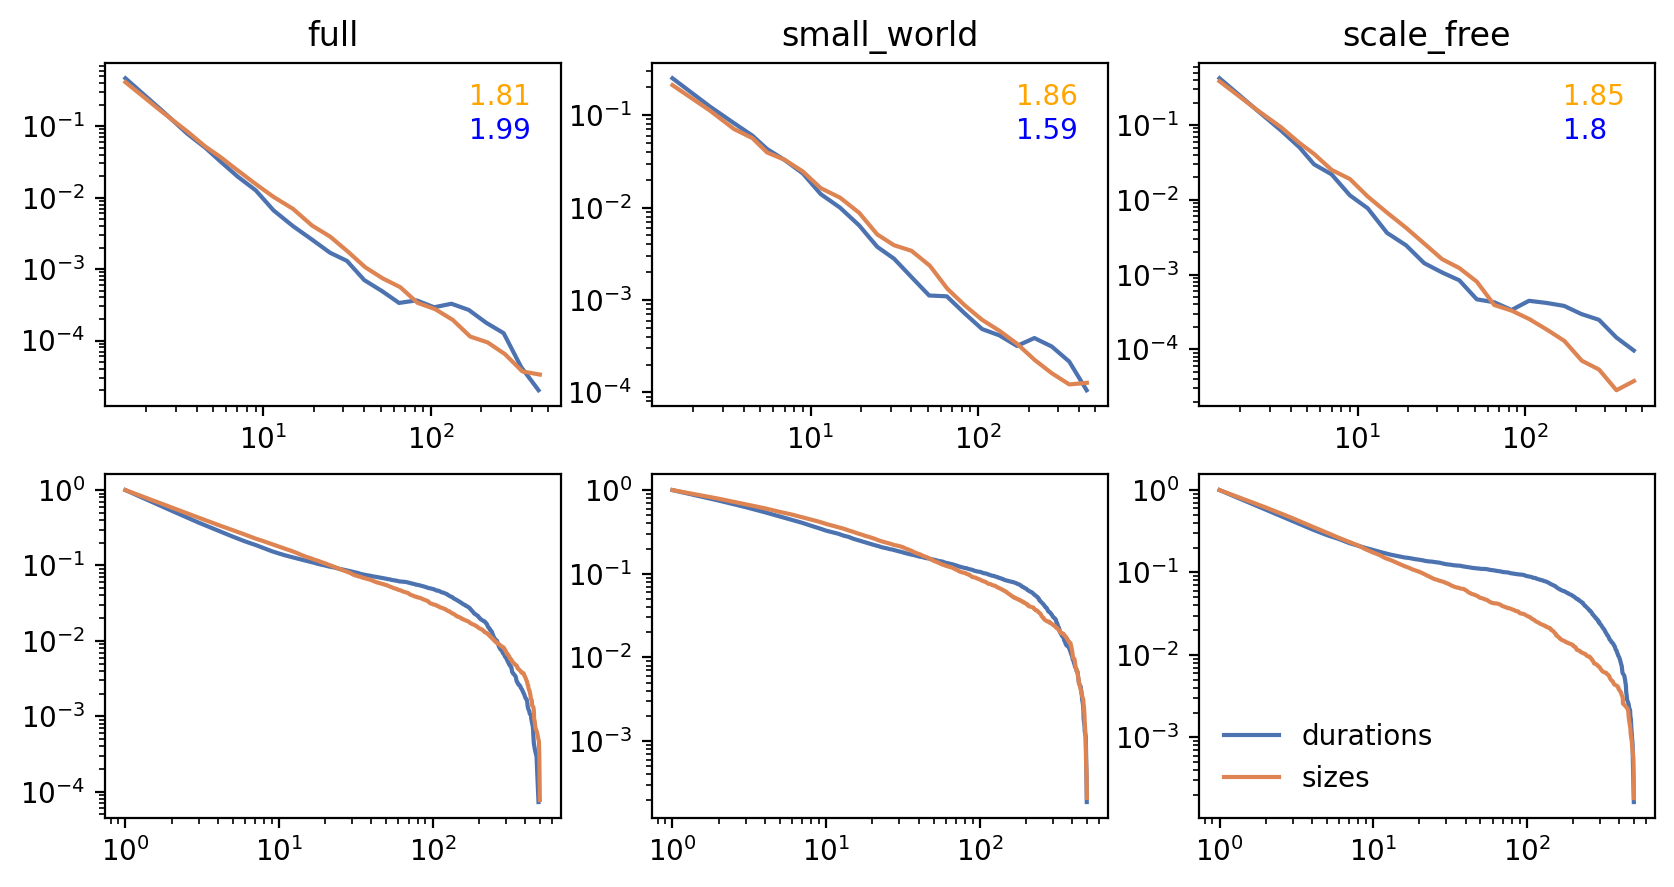

In [122]:
fig, ax = plt.subplots(2, 3, figsize=(10,5), dpi=200)

for col, topol in enumerate(['full', 'small_world', 'scale_free']):
    
    sizes = np.hstack(all_stats.query(f'topol == "{topol}"').avalanche_sizes.values)
    durations = np.hstack(all_stats.query(f'topol == "{topol}"').avalanche_durations.values)
    
    durations = powerlaw.trim_to_range(durations, xmin = 1, xmax = 500)
    sizes = powerlaw.trim_to_range(sizes, xmin = 1, xmax = 500)
    
    powerlaw.plot_pdf(durations, label='durations', ax=ax[0,col])
    powerlaw.plot_pdf(sizes, label='sizes', ax=ax[0,col])
    alpha_dur = powerlaw.Fit(durations).alpha.round(2)
    alpha_size = powerlaw.Fit(sizes).alpha.round(2)
    ax[0,col].text(.8, .8, alpha_dur, color='blue', horizontalalignment='left', 
                   verticalalignment='center', transform = ax[0,col].transAxes)
    ax[0,col].text(.8, .9, alpha_size, color='orange', horizontalalignment='left', 
                   verticalalignment='center', transform = ax[0,col].transAxes)
    

    powerlaw.plot_ccdf(durations, label='durations', ax=ax[1,col])
    powerlaw.plot_ccdf(sizes, label='sizes', ax=ax[1,col])
    
    ax[0,col].set_title(topol, fontsize=12)
    
plt.legend(frameon=False)

Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/usr/local/anaconda3/envs/criticality-on-neural-network/lib/python3.7/site-packages/powerlaw.p

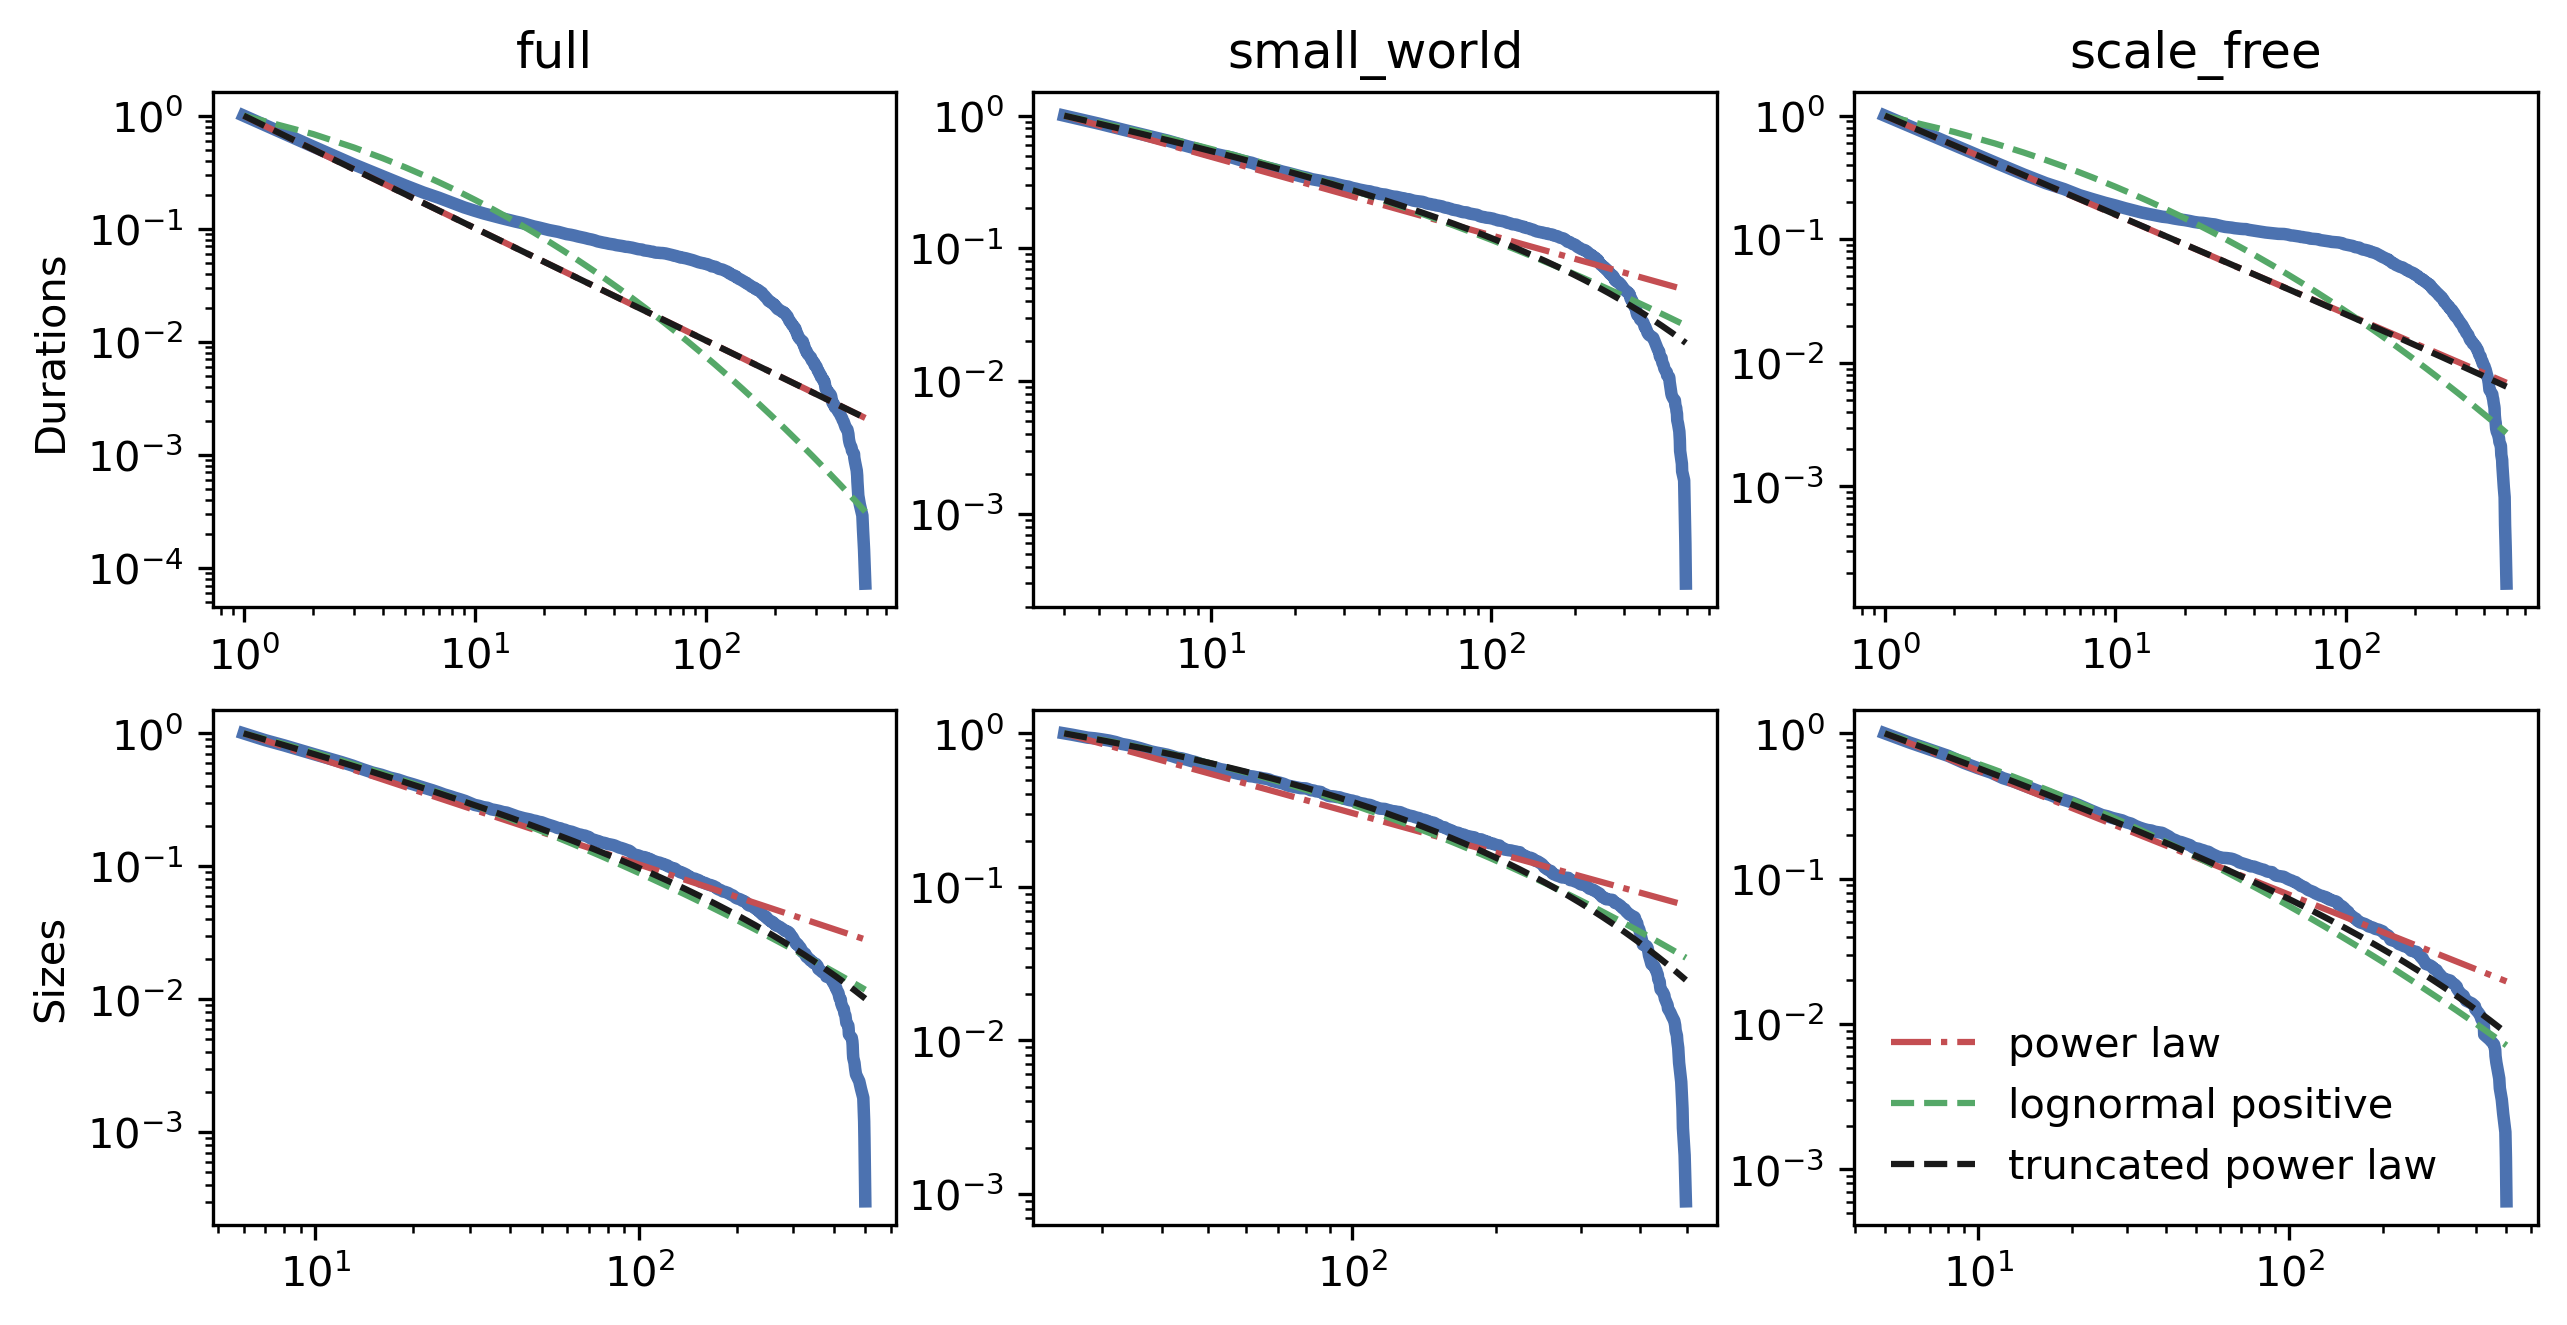

In [127]:
fig, ax = plt.subplots(2, 3, figsize=(10,5), dpi=300)

for col, topol in enumerate(['full', 'small_world', 'scale_free']):
    
    sizes = np.hstack(all_stats.query(f'topol == "{topol}"').avalanche_sizes.values)
    durations = np.hstack(all_stats.query(f'topol == "{topol}"').avalanche_durations.values)
    
    durations = powerlaw.trim_to_range(durations, xmin = 1, xmax = 500)
    sizes = powerlaw.trim_to_range(sizes, xmin = 1, xmax = 500)
    
    ax[0,col].set_title(topol, fontsize=12)

    for row, (measure, name) in enumerate(zip((durations, sizes), ('durations', 'sizes'))):
        
        plaw = powerlaw.Fit(measure)

#         for distribution in ['lognormal_positive', 
#                              'lognormal', 'truncated_power_law']:
#             R, p = transient_durations.distribution_compare('power_law', distribution)
#             print(distribution, R, p)

        plaw.plot_ccdf(linewidth=3, ax=ax[row, col])
        plaw.power_law.plot_ccdf(ax=ax[row, col], color='r', linestyle='-.', label = 'power law')
        plaw.lognormal_positive.plot_ccdf(ax=ax[row, col], color='g', linestyle='--', label = 'lognormal positive')
        plaw.truncated_power_law.plot_ccdf(ax=ax[row, col], color='k', linestyle='--', label = 'truncated power law')


ax[0,0].set_ylabel("Durations")        
ax[1,0].set_ylabel("Sizes")        
plt.legend(frameon=False)#         plt.title('Distributions fit of avalanche durations');